# SER model
A model of spreading excitations used in many disciplines (propagation of forest-fires, spread of epidemics, neuronal dynamics, etc.).  
SER stands for susceptible, excited and refractory.

In [1]:
using LightGraphs, Random, StatsBase, Plots, StaticGraphs

In [2]:
function init_states(n_vertices; prop_e=.1, prop_s=.45)
    n_e = Int(round(prop_e * n_vertices))
    n_s = Int(round(prop_s * n_vertices))
    
    states = zeros(Int, n_vertices) .- 1
    states[1:n_e] .= 1
    states[n_e: n_e + n_s] .= 0
    shuffle!(states)
    return states
end

init_states (generic function with 1 method)

In [ ]:
function update_states(
        states, g;
        prob_recovery=.1,
        prob_spont_act=.001,
        threshold=1,
    )
    new_states = zeros(Int, length(states))
    
    # Active always become refractory
    active_idx = findall(x -> x == 1, states)
    new_states[active_idx] .= -1        
    # Refractory become susceptible with prob_recovery
    refrac_idx = findall(x -> x == -1, states)
    recovered = rand(Float32, length(refrac_idx)) .< prob_recovery
    new_states[refrac_idx] = states[refrac_idx] + recovered
    # Susceptible become active if enough activation comes in
    suscept_idx = findall(x -> x == 0, states)
    spont_activated = rand(Float32, length(suscept_idx)) .< prob_spont_act
    
    n_active_neigbors = [        
        length(intersect(neighbors(g, v), active_idx))  # count active neighbors
        for v in suscept_idx
    ]         
    new_states[suscept_idx] .+= (n_active_neigbors .>= threshold) .| spont_activated
    return new_states
end

In [ ]:
function simulate(n_steps, g, states; prob_recovery=.1, prob_spont_act=.001, threshold=1,)                                                                            
    activity = zeros(Int, nv(g), n_steps)
    activity[:, 1] .= states
    anim = @animate for i=2:n_steps        
        activity[:, i] .= update_states(activity[:, i-1], 
                                        g,
                                        prob_recovery=prob_recovery,
                                        prob_spont_act=prob_spont_act,
                                        threshold=threshold)        
        plot(heatmap(activity), xlabel="Time", ylabel="Nodes", size=(800, 300),)
    end
    return activity, anim
end

In [51]:
g = erdos_renyi(500, .003)

{500, 367} undirected simple Int64 graph

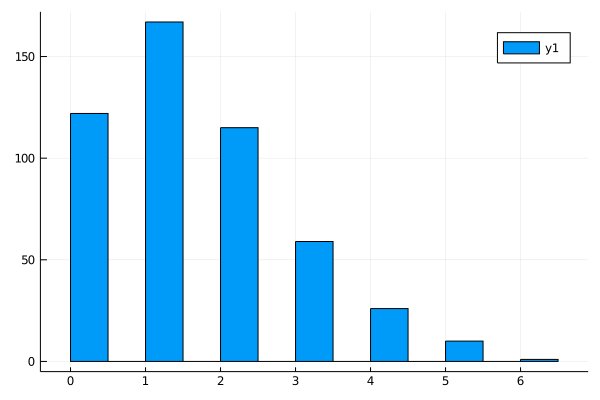

In [52]:
histogram(degree(g))

In [53]:
states = init_states(nv(g));

In [54]:
act, anim = simulate(200, g, states);

┌ Info: Saved animation to 
│   fn = /home/fabrizio/Dropbox/code/anim-ser.gif
└ @ Plots /home/fabrizio/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/home/fabrizio/Dropbox/code/anim-ser.gif")
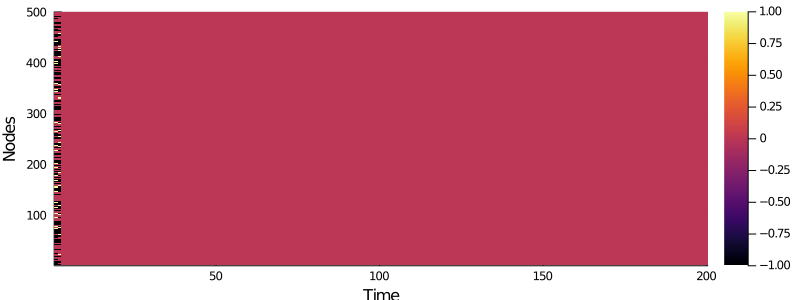

In [56]:
gif(anim, "anim-ser.gif", fps=50)